In [2]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 89kB/s 


In [3]:
#挂载云盘
import os
from google.colab import drive
drive.mount('/content/drive')

#切换到项目文件夹
path = "/content/drive/MyDrive/project/VoxelMorph-torch-master"
os.chdir(path)
os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['vmtrain.ipynb',
 'README.md',
 'test.py',
 'train.py',
 '.idea',
 'Log',
 'Model',
 'Checkpoint',
 'Result',
 'vmtest.ipynb']

In [4]:
# third party imports
import numpy as np
import nibabel as nb
import glob
import matplotlib.pyplot as plt

# python imports
import glob
import warnings
# external imports
import torch
import numpy as np
import SimpleITK as sitk
from torch.optim import Adam
import torch.utils.data as Data
# internal imports
from Model import losses
from Model.config import args
from Model.datagenerators import Dataset
from Model.model import U_Network, SpatialTransformer

#train.py


In [12]:
def count_parameters(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params


def make_dirs():
    if not os.path.exists(args.model_dir):
        os.makedirs(args.model_dir)
    if not os.path.exists(args.log_dir):
        os.makedirs(args.log_dir)
    if not os.path.exists(args.result_dir):
        os.makedirs(args.result_dir)


def save_image(img, ref_img, name):
    img = sitk.GetImageFromArray(img[0, 0, ...].cpu().detach().numpy())
    img.SetOrigin(ref_img.GetOrigin())
    img.SetDirection(ref_img.GetDirection())
    img.SetSpacing(ref_img.GetSpacing())
    sitk.WriteImage(img, os.path.join(args.result_dir, name))



In [13]:
def train():
    # 创建需要的文件夹并指定gpu
    make_dirs()
    device = torch.device('cuda:{}'.format(args.gpu) if torch.cuda.is_available() else 'cpu')

    # 日志文件
    log_name = str(args.n_iter) + "_" + str(args.lr) + "_" + str(args.alpha)
    print("log_name: ", log_name)
    f = open(os.path.join(args.log_dir, log_name + ".txt"), "w")

    # 读入fixed图像
    f_img = sitk.ReadImage(args.atlas_file)
    input_fixed = sitk.GetArrayFromImage(f_img)[np.newaxis, np.newaxis, ...]
    vol_size = input_fixed.shape[2:]
    # [B, C, D, W, H]
    input_fixed = np.repeat(input_fixed, args.batch_size, axis=0) #batch轴重复扩增到batchsize
    input_fixed = torch.from_numpy(input_fixed).to(device).float()

    # 创建配准网络（UNet）和STN
    nf_enc = [16, 32, 32, 32]
    if args.model == "vm1":
        nf_dec = [32, 32, 32, 32, 8, 8]
    else:
        nf_dec = [32, 32, 32, 32, 32, 16, 16]
    UNet = U_Network(len(vol_size), nf_enc, nf_dec).to(device)
    STN = SpatialTransformer(vol_size).to(device)
    UNet.train()
    STN.train()
    # 模型参数个数
    print("UNet: ", count_parameters(UNet))
    print("STN: ", count_parameters(STN))

    # Set optimizer and losses
    opt = Adam(UNet.parameters(), lr=args.lr)
    sim_loss_fn = losses.ncc_loss if args.sim_loss == "ncc" else losses.mse_loss
    grad_loss_fn = losses.gradient_loss

    # Get all the names of the training data
    img_path = 'aligned_norm' + '.nii.gz'
    segm_path = 'aligned_seg4' + '.nii.gz'
    subjects_list = glob.glob(args.train_dir + '/*' )
    all_files = [x + '/' +img_path for x in subjects_list] #每个subject文件名,list

    #training
    train_files = all_files[0:30]
    DS = Dataset(files=train_files)
    print("Number of training images: ", len(DS))
    
    DL = Data.DataLoader(DS, batch_size=args.batch_size, shuffle=True, num_workers=0, drop_last=True)

    # Training loop.
    for i in range(1, args.n_iter + 1):
        # Generate the moving images and convert them to tensors.
        input_moving = iter(DL).next()
        # [B, C, D, W, H]
        input_moving = input_moving.to(device).float()

        # Run the data through the model to produce warp and flow field
        flow_m2f = UNet(input_moving, input_fixed)
        m2f = STN(input_moving, flow_m2f)

        # Calculate loss
        sim_loss = sim_loss_fn(m2f, input_fixed)
        grad_loss = grad_loss_fn(flow_m2f)
        loss = sim_loss + args.alpha * grad_loss
        print("i: %d  loss: %f  sim: %f  grad: %f" % (i, loss.item(), sim_loss.item(), grad_loss.item()), flush=True)
        print("%d, %f, %f, %f" % (i, loss.item(), sim_loss.item(), grad_loss.item()), file=f)

        # Backwards and optimize
        opt.zero_grad()
        loss.backward()
        opt.step()

        if i % args.n_save_iter == 0:
            # Save model checkpoint
            save_file_name = os.path.join(args.model_dir, '%d.pth' % i)
            torch.save(UNet.state_dict(), save_file_name)
            # Save images
            m_name = str(i) + "_m.nii.gz"
            m2f_name = str(i) + "_m2f.nii.gz"
            save_image(input_moving, f_img, m_name)
            save_image(m2f, f_img, m2f_name)
            print("warped images have saved.")
    f.close()

In [ ]:
if __name__ == "__main__":
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=DeprecationWarning)
    train()

#plot

Text(0.5, 0.98, 'Center slices for fixed image')

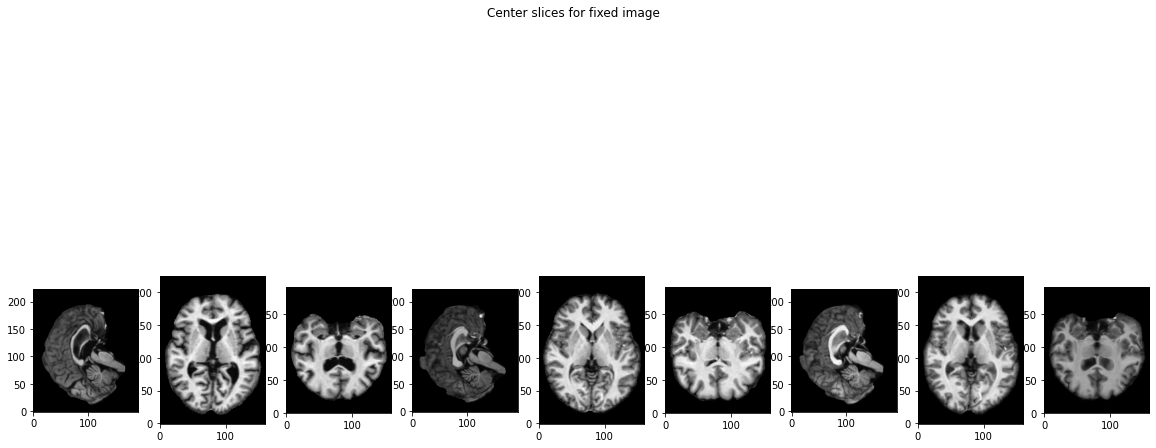

In [14]:
fixed_img = nb.load(args.atlas_file)
moving_img = nb.load('/content/drive/MyDrive/Result/1000_m.nii.gz')
m2f = nb.load('/content/drive/MyDrive/Result/1000_m2f.nii.gz')

def show_slices(slices):
   """ Function to display row of image slices """
   fig, axes = plt.subplots(1, len(slices),figsize = (20, 10))
   for i, slice in enumerate(slices):
       axes[i].imshow(slice.T, cmap="gray", origin="lower")

def slices_of_img(img):
  slice_0 = img.get_fdata()[img.shape[0]//2, :, :]
  slice_1 = img.get_fdata()[:, img.shape[1]//2, :]
  slice_2 = img.get_fdata()[:, :, img.shape[2]//2]
  return [slice_0, slice_1, slice_2]


slices =slices_of_img(fixed_img)+ slices_of_img(moving_img)+slices_of_img(m2f)
show_slices(slices)


plt.suptitle("Center slices for fixed image")



# 新段落